# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

In this assigment we will be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

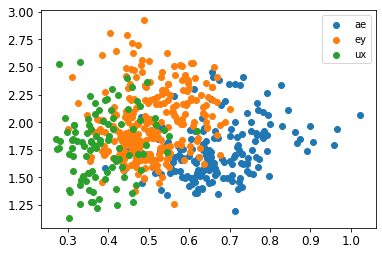

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12) 

# %matplotlib notebook

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']


vow_dict = {"ae":aes, "ey":eys, "ux":uxs}
# Plotting here
for key, vow in vow_dict.items():
    plt.scatter(vow["F1"], vow["F2"], label=f"{key}")
    plt.legend()
plt.show()

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

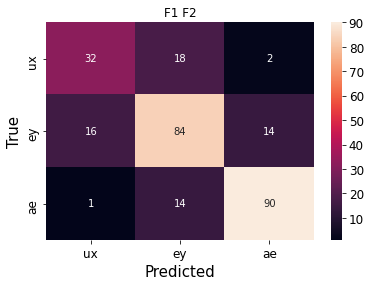

In [5]:
import seaborn as sns # For confusion matrix
from scipy.stats import multivariate_normal

# extracting means and covariance

means = {}
covs = {}
for key, vow in vow_dict.items():
    tmp = np.array([[f1, f2] for f1, f2 in zip(vow["F1"], vow["F2"])])
    means[key] = np.array(np.mean(tmp, axis=0))
    covs [key] = np.array(np.cov(np.array(tmp.T))) # Litt usikker på denne

rvs = []
keys = ["ae", "ey", "ux"]
# Sorting list so keys with lowest mean comes first, helpful for plotting later 
keys = sorted([(key, means[key]) for key in keys],key=lambda x: x[1][0]) 
keys = [k for k, _ in keys]
             
for key in keys:
    rv = multivariate_normal(mean=means[key], cov=covs[key])
    rvs.append(rv) 

aes_test = test[test["Phoneme"] == 'ae']
eys_test = test[test["Phoneme"] == 'ey']
uxs_test = test[test["Phoneme"] == 'ux']

vow_test_dict = {"ae": aes_test, "ey": eys_test, "ux": uxs_test}

f_matrix = {}
for key, vow in vow_test_dict.items():
    f_matrix[key] = np.array([[f1, f2] for f1, f2 in zip(vow["F1"], vow["F2"])])

# Note f_matrix has first shape 3, but the different vowels have different number of samples for F1 and F2.
# However the number of F1 and F2 is the same for a vowel 
    
def predict(f_mat, keys, rvs):
    confusion_mat = np.zeros((len(f_mat), len(f_mat)))
    for i, key  in enumerate(keys):
        values = f_matrix[key]
        preds = []

        for rv in rvs:
            preds.append(np.log(rv.pdf(values)))
        preds = np.argmax(preds, axis=0)

        for pred in preds:
            confusion_mat[i,pred] += 1
    return confusion_mat
        

def plot_conf(confusion_mat, plot_title, keys):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.heatmap(confusion_mat, annot=True,xticklabels=keys, yticklabels=keys, ax=ax)
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    ax.set_title(plot_title)
    plt.show()
    
confusion_mat = predict(f_matrix, keys, rvs)
plot_conf(confusion_mat, "F1 F2", keys)
    



*Try:* To visualize the classes models and the classifier created in (b), you can:

- Plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$.
- Plot the decision regions for the Bayesian classifier.

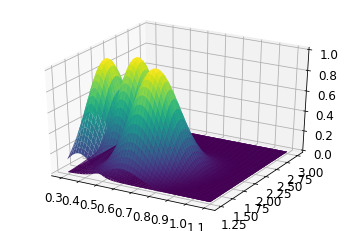

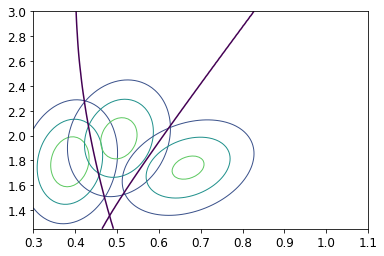

In [6]:
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection="3d") 
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)


x = np.linspace(0.3,1.1, num=100)
y = np.linspace(1.25,3, num=100)
x, y = np.meshgrid(x, y)
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
zs = []
for rv in rvs[:]:
    z = rv.pdf(pos)/np.max(rv.pdf(pos))
    zs.append(z)
    ax.plot_surface(x,y,z,  cmap='viridis')
    ax2.contour(x,y,rv.pdf(pos), linewidths=1, levels=3) 

# Drawing decision boundary
lines = [zs[i] - zs[i+1] for i in range(2)]
for l in lines:
    ax2.contour(x, y, l, levels=[0])

plt.show()

(c) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (b). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

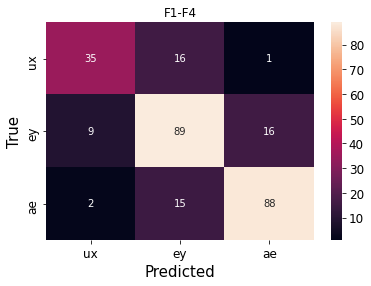

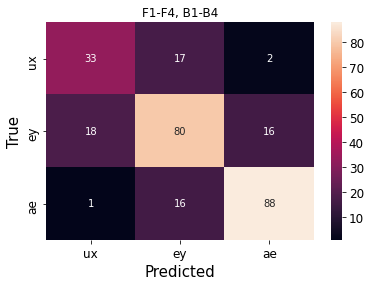

In [7]:

# extracting means and covariance for classifier
def make_rvs(vow_dict, drop_list, diag_cov=False):
    means = {}
    covs = {}
    for key, vow in vow_dict.items():
        tmp = vow.drop(drop_list,axis=1).values
        means[key] = np.array(np.mean(tmp, axis=0))
        tmp_cov = np.array(np.cov(np.array(tmp.T)))
        if diag_cov:
            tmp_cov = tmp_cov*np.eye(tmp_cov.shape[0]) # Makes diagonal matrix
        covs[key] = tmp_cov # Litt usikker på denne

    rvs = []
    for key in keys:
        rv = multivariate_normal(mean=means[key], cov=covs[key])
        rvs.append(rv)
    return rvs
    
    
drop_l = ["SpeakerID", "Gender", "Phoneme", "B1", "B2", "B3", "B4"]

f_matrix = {}
for key, vow in vow_test_dict.items():
    f_matrix[key] = vow.drop(drop_l,axis=1).values
    
rvs = make_rvs(vow_dict, drop_l)
conf_mat = predict(f_matrix, keys, rvs)
plot_conf(conf_mat, "F1-F4", keys)

# extracting means and covariance for classifier
# Using all available information
drop_l = ["SpeakerID", "Gender", "Phoneme"]

f_matrix = {}
for key, vow in vow_test_dict.items():
    f_matrix[key] = vow.drop(["SpeakerID", "Gender", "Phoneme" ],axis=1).values
    
rvs = make_rvs(vow_dict, drop_l)
conf_mat = predict(f_matrix, keys, rvs)
plot_conf(conf_mat, "F1-F4, B1-B4", keys)



(d) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (c).

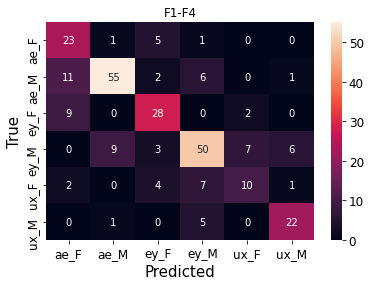

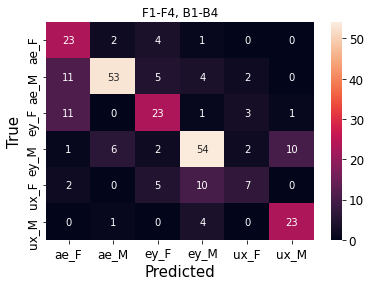

In [8]:
# Separating based on gender
vow_dict_g = {}
for key, vow in vow_dict.items():
    vow_dict_g[key+"_F"] = vow.loc[vow['Gender'] == "F"]
    vow_dict_g[key+"_M"] = vow.loc[vow['Gender'] == "M" ]
    
vow_dict_t_g = {}
for key, vow in vow_test_dict.items():
    vow_dict_t_g[key+"_F"] = vow.loc[vow['Gender'] == "F"]
    vow_dict_t_g[key+"_M"] = vow.loc[vow['Gender'] == "M" ]

    
keys = list(vow_dict_g.keys())

# Using F1- F4
drop_l = ["SpeakerID", "Gender", "Phoneme", "B1", "B2", "B3", "B4"]

rvs = make_rvs(vow_dict_g, drop_l)

f_matrix = {}
for key, vow in vow_dict_t_g.items():
    f_matrix[key] = vow.drop(drop_l ,axis=1).values
    
conf_mat = predict(f_matrix, keys, rvs)
plot_conf(conf_mat, "F1-F4", keys)

# Using all features
drop_l = ["SpeakerID", "Gender", "Phoneme"]

rvs = make_rvs(vow_dict_g, drop_l)

f_matrix = {}
for key, vow in vow_dict_t_g.items():
    f_matrix[key] = vow.drop(drop_l ,axis=1).values
    
conf_mat = predict(f_matrix, keys, rvs)
plot_conf(conf_mat, "F1-F4, B1-B4", keys)

(e) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (d) using only diagonal covariance matrices and compare the results.

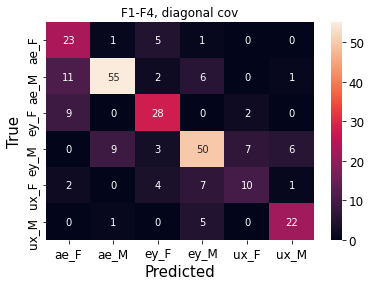

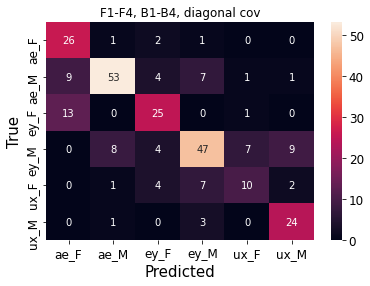

In [9]:
# Using F1- F4
drop_l = ["SpeakerID", "Gender", "Phoneme", "B1", "B2", "B3", "B4"]

rvs = make_rvs(vow_dict_g, drop_l)

f_matrix = {}
for key, vow in vow_dict_t_g.items():
    f_matrix[key] = vow.drop(drop_l ,axis=1).values
    
conf_mat = predict(f_matrix, keys, rvs)
plot_conf(conf_mat, "F1-F4, diagonal cov", keys)

# Using all features
drop_l = ["SpeakerID", "Gender", "Phoneme"]

rvs = make_rvs(vow_dict_g, drop_l, True)

f_matrix = {}
for key, vow in vow_dict_t_g.items():
    f_matrix[key] = vow.drop(drop_l ,axis=1).values
    
conf_mat = predict(f_matrix, keys, rvs)
plot_conf(conf_mat, "F1-F4, B1-B4, diagonal cov", keys)

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

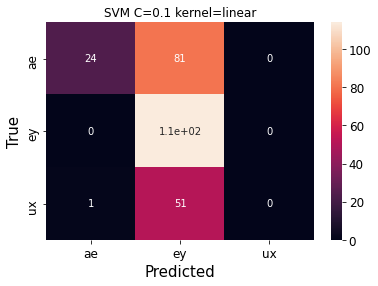

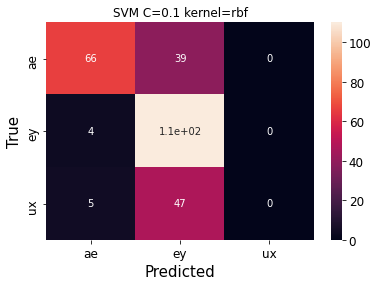

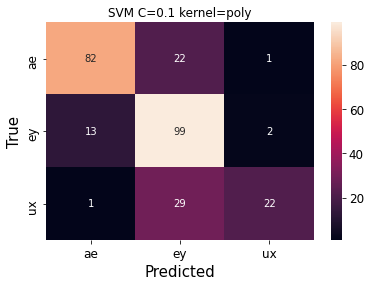

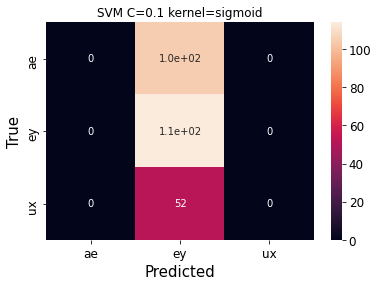

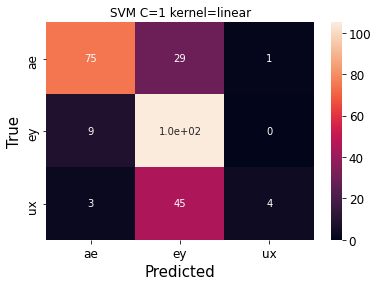

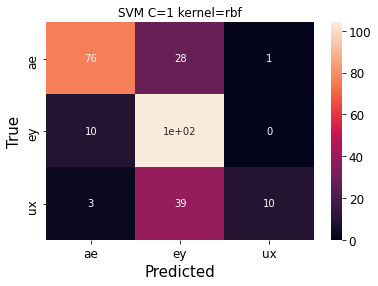

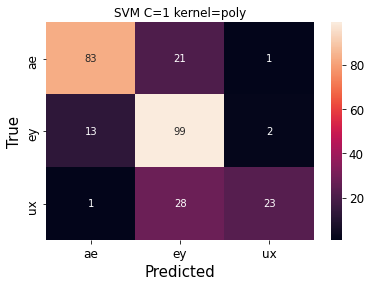

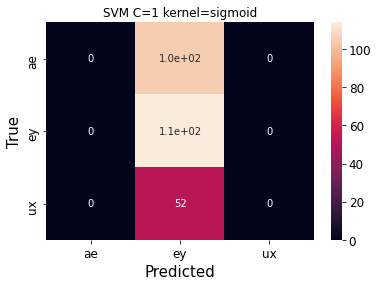

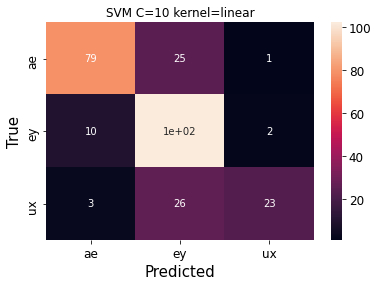

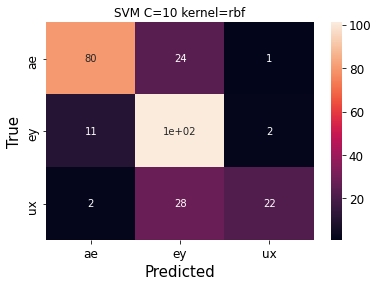

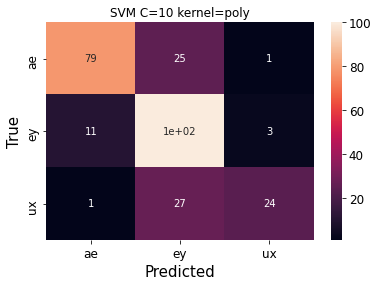

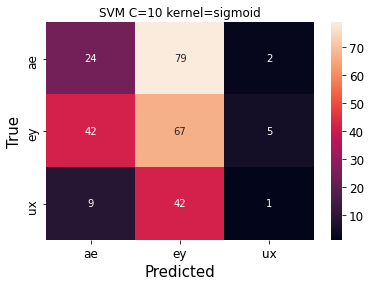

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#Organize the data
drop_l = ["SpeakerID", "Gender", "Phoneme", "F3","F4","B1", "B2", "B3", "B4"]
keys = list(vow_dict.keys())
Y_train = []
X_train = []
X_test = []
Y_test = []

for key in keys:
    vow_train = vow_dict[key]
    train_vals = vow_train.drop(drop_l,axis=1).values
    X_train.extend(train_vals)
    Y_train.extend([1*keys.index(key) for _ in range(len(train_vals))])
    
    vow_test = vow_test_dict[key]
    test_vals = vow_test.drop(drop_l,axis=1).values
    X_test.extend(test_vals)
    Y_test.extend([1*keys.index(key) for _ in range(len(test_vals))])
    
    
# Train the classifier
Cs = [0.1,1,10]
for c in Cs:
    for kernel in ["linear", "rbf", "poly", "sigmoid"]:
        cls = SVC(kernel=kernel,C=c)
        cls.fit(X_train, Y_train)
        res = cls.predict(X_test)
        conf_mat = confusion_matrix(Y_test, res)
        plot_conf(conf_mat, f"SVM C={c} kernel={kernel}", keys)


(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?